In [1]:

import tensorflow as tf
import keras
from keras.api.utils  import  to_categorical
from keras.api  import  Input, regularizers
from keras.api.layers  import  Dense, Dropout, Conv2D, MaxPooling2D, Flatten, AveragePooling2D, GlobalMaxPooling2D, Concatenate, BatchNormalization
from keras.api.models  import  Model 
from keras.api.optimizers import Adam, SGD
from keras.api.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau, LambdaCallback
from keras.api.models import load_model

import numpy as np

import matplotlib.pyplot as plt
import  os 
import random
import numpy as np



random_seed = 42
random.seed(random_seed)

tf.random.set_seed(random_seed)
keras.random.SeedGenerator(random_seed)

2024-12-17 13:31:44.520391: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-17 13:31:44.528454: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734435104.537975    9314 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734435104.540696    9314 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-17 13:31:44.550981: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

In [3]:


for i in [X_train, y_train, X_test, y_test]:
    print(i.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


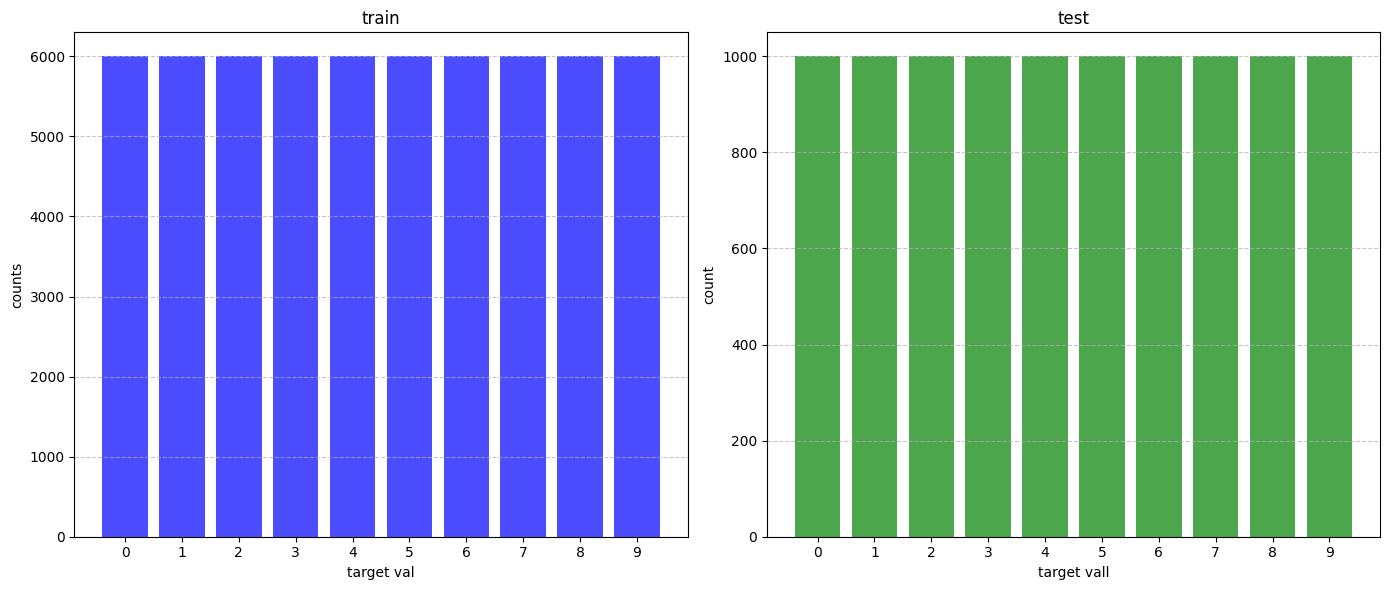

In [4]:
unique_train, counts_train = np.unique(y_train, return_counts=True)
unique_test, counts_test = np.unique(y_test, return_counts=True)


plt.figure(figsize=(14, 6))

# для тренувальної вибірки
plt.subplot(1, 2, 1)
plt.bar(unique_train, counts_train, color='blue', alpha=0.7)
plt.title('train')
plt.xlabel('target val')
plt.ylabel('counts')
plt.xticks(unique_train)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# для тестової вибірки
plt.subplot(1, 2, 2)
plt.bar(unique_test, counts_test, color='green', alpha=0.7)
plt.title('test')
plt.xlabel('target vall')
plt.ylabel('count')
plt.xticks(unique_test)
plt.grid(axis='y', linestyle='--', alpha=0.7)


plt.tight_layout()
plt.show()

# маємо ідеально збалансовнай датасет 

In [5]:
# подивимось чим взагалі є наші таргети 
np.unique(y_test)

# знов маємо просто мітки класів від 0 до 9

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

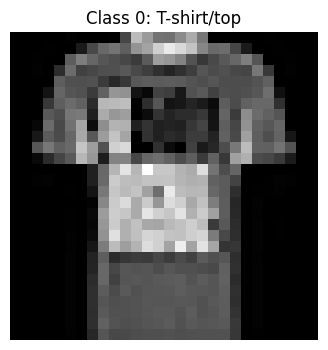

In [6]:
# підгледіли в документації назви до міток класів
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", 
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# Виведемо рандомне зображення - подивитись з чим хоч маємо справу

random_index = np.random.randint(0, X_train.shape[0])  # Випадковий індекс
random_image = X_train[random_index]
random_label = y_train[random_index]


plt.figure(figsize=(4, 4))
plt.imshow(random_image, cmap='gray')
plt.title(f"Class {random_label}: {class_names[random_label]}")
plt.axis('off')
plt.show()

np.random.seed(random_seed) # далі про всяк випадок увімкнемо відтворюваність результатів в numpy

In [ ]:
# нормалізуємо значення в діапазон від 0 до 1
X_train, X_test = map(lambda x: x / 255, [X_train, X_test])
print(np.min(X_train), " - ", np.max(X_train))

0.0  -  1.0


In [8]:
# як і в попередній домашці не бачу сенсу перетворювати таргети у вектора, тож таргети залишаться як є.

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def build_confusion_matrix(y_pred, y_true, save_to=None):
    predicted_classes = np.argmax(y_pred, axis=1) # predicted_res представлено у вигляді вектора з імовірностями, тож нам потрібен індекс найищого значення

    c_matrix = confusion_matrix(y_test, predicted_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=c_matrix, display_labels=np.unique(y_true))
    disp.plot(cmap=plt.cm.coolwarm)

    if save_to:
        plt.savefig(os.path.join(save_to, f"confusion_matrix.png"))
        plt.close()

In [9]:
def get_path(log_dir):
    # створює унікальний шлях до директорії з логами
    i = 0
    while(True):
        log_path = os.path.join(log_dir, str(i))
        if not os.path.isdir(log_path):
            return log_path
        i = i + 1

In [10]:
logpath = get_path("./model_logs")
best_model_path = os.path.join(logpath, "best_model.keras")
EPOCHS = 200

In [11]:
def scheduler(epoch, lr):
    # функція знижує lr при досягненні половини та трьох чвертей із запланованих епох для більш плавного спуску по градієнту
    if epoch == round(EPOCHS * .5):
        return lr *.7
    elif epoch == round(EPOCHS * .75):
        return lr * .3
    return lr

In [12]:
from collections import defaultdict
from keras.api.callbacks import Callback


class PlotCallback(Callback):
    def __init__(self, log_path, figsize:tuple=(15, 10)):
        super().__init__()
        self.log_path = log_path
        self.metrics = defaultdict(list)
        self.figsize = figsize

        if not os.path.exists(self.log_path):
            os.makedirs(self.log_path)

    def on_epoch_end(self, epoch, logs=None):
        for key in logs.keys():
            self.metrics[key].append(logs[key])
        
        self._plot_metrics()

    def _plot_metrics(self):
        
        for metric in self.metrics:
            if "val_" in metric:
                continue
            plt.figure(figsize=self.figsize)
            plt.plot(self.metrics[metric], label=metric)
            validation_pair = self.metrics.get(f"val_{metric}", None)

            if validation_pair is not None:
                plt.plot(validation_pair, label=f"val_{metric}")
        
            plt.xlabel("epoch")
            plt.ylabel(metric)
            plt.title(f"training and validation {metric}")
            plt.legend()
            plt.grid(True)
            plt.savefig(os.path.join(self.log_path, f"{metric}.png"))
            plt.close()

In [13]:
num_classes = len(np.unique(y_test))


In [14]:
# створимо модель 
l2 = 0.001

input = Input(shape=(28, 28, 1))
conv1 = Conv2D(32, (3, 3), (1, 1), padding="same", activation="relu", kernel_regularizer=regularizers.l2(l2))(input)
bn = BatchNormalization()(conv1)
pooling1 = MaxPooling2D((2, 2), (2, 2))(bn) # зменшили зображення в 4 рази (14 х 14)
# pooling1 = AveragePooling2D((2, 2), (1, 1))(conv1) # зменшили зображення в 4 рази (14 х 14)
# pooling1 = GlobalMaxPooling2D()(conv1) 

conv2 = Conv2D(64, (3, 3), (1, 1), padding="same", activation="relu", kernel_regularizer=regularizers.l2(l2))(pooling1)  # створення щє одного Conv2D та MaxPooling2D шарів допомогло підняти accuracy на 2%
bn = BatchNormalization()(conv2)
pooling2 = MaxPooling2D((2, 2), (2, 2))(bn) # зменшили зображення в 4 рази (7 х 7)
# pooling2 = AveragePooling2D((2, 2), (2, 2))(conv2) # зменшили зображення в 4 рази (7 х 7)
# pooling2 = GlobalMaxPooling2D()(conv2) 
flatten = Flatten()(pooling2)
# output = Dense(num_classes, activation="softmax")(flatten) 
dense1 = Dense(128, activation="relu", kernel_regularizer=regularizers.l2(l2))(flatten)
dropout = Dropout(0.5)(dense1)
output = Dense(num_classes, activation="softmax", kernel_regularizer=regularizers.l2(l2))(dropout) # з додаванням l2 регулярізації проблема з перенавчанням схоже пропала

default_conv_model = Model(inputs=input, outputs=output)


# MaxPooling2D -> 91.46%
# AveragePooling2D -> 89.99%  - гірший результат може бути пов'язаний з "розмиттям" ознак на мапах ознак
# GlobalMaxPooling2D -> 65% можливо, його застосування потребує більш складної моделі

# вцілому схоже що для роботи з простими датасетами такими як fashion mnist є ефективним викроистання MaxPooling2D
default_conv_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 422,026 (1.61 MB)

 Trainable params: 421,834 (1.61 MB)

 Non-trainable params: 192 (768.00 B)

In [11]:
optimizer = SGD(learning_rate=0.1)
default_conv_model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
              

In [15]:
# додамо декілька чекпоінтів

best_model_cp = ModelCheckpoint(best_model_path, save_best_only=True, monitor="val_accuracy", verbose=1)
plot_cb = PlotCallback(log_path=logpath)
lr_scheduler_cb = LearningRateScheduler(scheduler, verbose=1)
plateu_down_cb = ReduceLROnPlateau(monitor="val_accuracy", factor=0.9, patience=10, min_delta=0.00001, min_lr=0.0001)
early_stopping_cb = EarlyStopping(monitor="val_accuracy", min_delta=0.000001, patience=20, restore_best_weights=False, start_from_epoch=10, verbose=1)

In [16]:
default_conv_model.fit(X_train, y_train,
        batch_size=252,
        epochs=EPOCHS,
        verbose=1,
        validation_split=0.15,
        callbacks=[best_model_cp, early_stopping_cb, plateu_down_cb, lr_scheduler_cb, plot_cb]
        )

score = default_conv_model.evaluate(X_test, y_test, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])


Epoch 1: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 1/200


2024-12-16 20:17:37.509445: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_942', 164 bytes spill stores, 164 bytes spill loads



203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6189 - loss: 1.6836
Epoch 1: val_accuracy improved from -inf to 0.39578, saving model to ./model_logs/3/best_model.keras
203/203 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.6195 - loss: 1.6809 - val_accuracy: 0.3958 - val_loss: 2.5433 - learning_rate: 0.1000

Epoch 2: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 2/200
197/203 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8229 - loss: 0.7863
Epoch 2: val_accuracy improved from 0.39578 to 0.72722, saving model to ./model_logs/3/best_model.keras
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8232 - loss: 0.7854 - val_accuracy: 0.7272 - val_loss: 0.9982 - learning_rate: 0.1000

Epoch 3: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 3/200
183/203 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8487 - loss: 0.6976
Epoch 3: val_accuracy improved from 0.72722 to 0.77800, saving model to ./model_logs/3/best_model.keras
20

In [23]:
y_pred = default_conv_model.predict(X_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


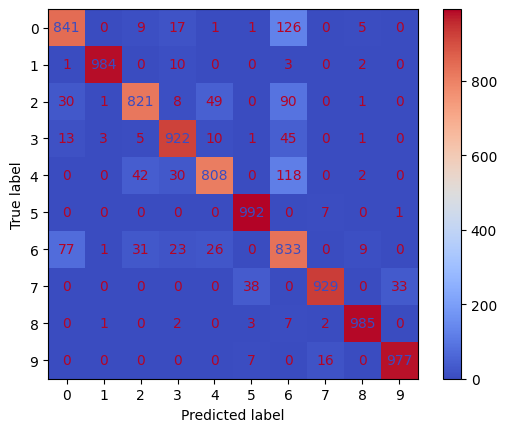

In [19]:
build_confusion_matrix(y_pred=y_pred, y_true=y_test)

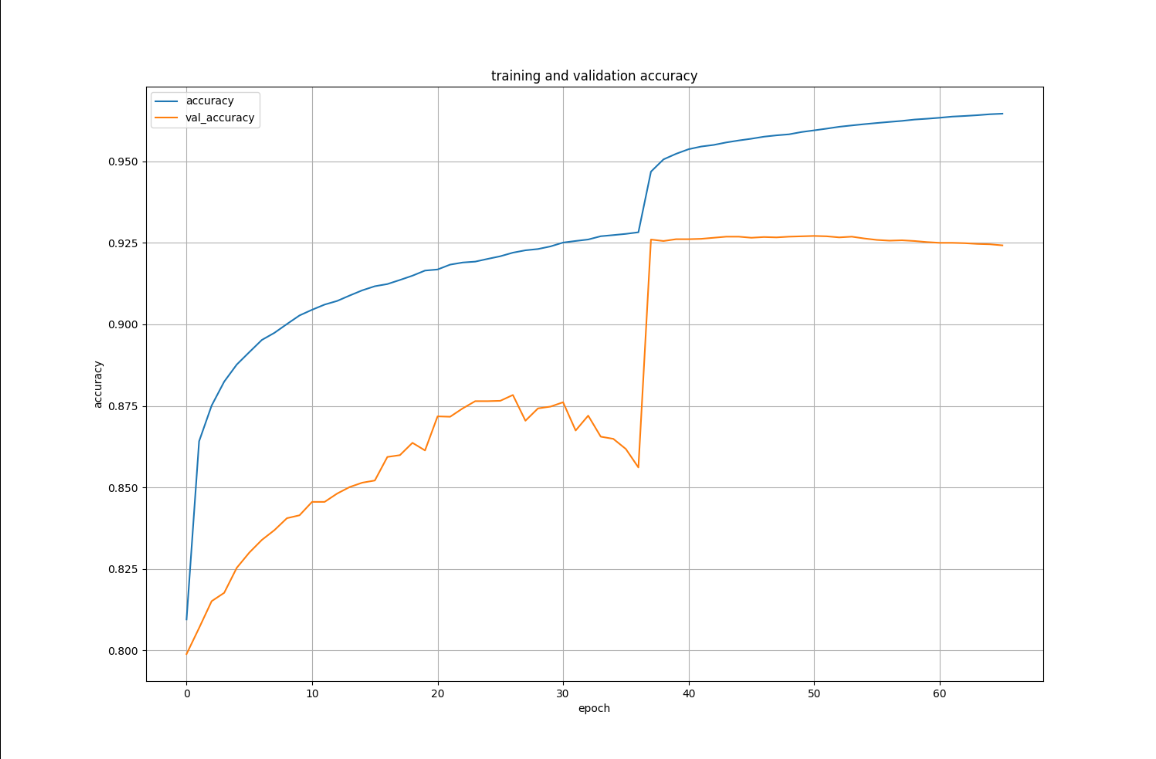 
тут ми можемо побачити як відпрацював наш plateu_down_cb перед спрацюваннням модель почала явно перенавчатись, але за рахунок зниження learning_rate модель змогла знайти оптимальні ваги для виходу з плато. графік не з поточного тренування. але відображає цікаву інформацію (графік з якогось попереднього навчання)

In [20]:
# збережемо, на випадок якщо знов відключать світло

default_conv_model.save(os.path.join(logpath, "default_conv_model.keras"))

In [16]:
# подивимось що нам скаже модель з прошлої домашки яка була побудована тільки на dense шарах
X_train_vect = X_train.reshape(X_train.shape[0], -1)
X_test_vect = X_test.reshape(X_test.shape[0], -1)

In [24]:


best_model_cp = ModelCheckpoint(best_model_path, save_best_only=True, monitor="val_accuracy", verbose=1) # потрібно оновити стан чекпоінта

input = Input(shape=(X_train_vect.shape[1], )) # кількість входів має відповідати кількості елементів вектора, що подається
hidden_1 = Dense(20, activation="relu", )(input)
output = Dense(num_classes, activation="softmax")(hidden_1)
only_dense_model = Model(inputs=input, outputs=output)

optimizer = SGD(learning_rate=0.1)
only_dense_model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,  
              metrics=['accuracy'])

only_dense_model.fit(X_train_vect, y_train,
        batch_size=252,
        epochs=EPOCHS,
        verbose=1,
        validation_split=0.15,
        callbacks=[best_model_cp, early_stopping_cb, lr_scheduler_cb, plateu_down_cb, plot_cb]
        )

score = only_dense_model.evaluate(X_test_vect, y_test, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])


Epoch 1: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 1/200


2024-12-17 13:35:12.198674: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_219', 148 bytes spill stores, 148 bytes spill loads



203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5787 - loss: 1.2147
Epoch 1: val_accuracy improved from -inf to 0.69100, saving model to ./model_logs/4/best_model.keras
203/203 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5792 - loss: 1.2132 - val_accuracy: 0.6910 - val_loss: 0.8861 - learning_rate: 0.1000

Epoch 2: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 2/200
159/203 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - accuracy: 0.7814 - loss: 0.6145
Epoch 2: val_accuracy improved from 0.69100 to 0.74189, saving model to ./model_logs/4/best_model.keras
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7843 - loss: 0.6073 - val_accuracy: 0.7419 - val_loss: 0.7189 - learning_rate: 0.1000

Epoch 3: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 3/200
197/203 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step - accuracy: 0.8158 - loss: 0.5216
Epoch 3: val_accuracy improved from 0.74189 to 0.77144, saving model to ./model_logs/4/best_model.keras


бачимо що звичайна модель на dense шарах показала значно слабший результат,ніж CNN



In [24]:
only_dense_model.save(os.path.join(logpath, "only_dense_model.keras"))

Заради практики побудуємо трохи складнішу архітектуру

In [25]:
l2 = 0.001
l2_reg = regularizers.l2

input = Input(shape=(28, 28, 1))

# Шлях 1 - більш загальні ознаки

conv1 = Conv2D(32, (5, 5), (2, 2), padding="same",kernel_regularizer=l2_reg(l2), activation="relu")(input)
bn1 = BatchNormalization()(conv1)
pooling1 = MaxPooling2D((2, 2), (1, 1))(bn1)

conv1 = Conv2D(64, (3, 3), (1, 1), padding="same",kernel_regularizer=l2_reg(l2), activation="relu")(pooling1)
bn1 = BatchNormalization()(conv1)
pooling1 = MaxPooling2D((2, 2), (2, 2))(bn1)

flatten1 = Flatten()(pooling1)
dense1 = Dense(64, activation="relu", kernel_regularizer=l2_reg(l2))(flatten1)
d1 = Dropout(0.5)(dense1)

# шлях 2 - більш деталізовані ознаки

conv2 = Conv2D(32, (3, 3), (1, 1), padding="same", kernel_regularizer=l2_reg(l2), activation="relu")(input)
bn2 = BatchNormalization()(conv2)
pooling3 = MaxPooling2D((2, 2), (2, 2))(bn2)

conv2 = Conv2D(64, (3, 3), (1, 1), padding="same", kernel_regularizer=l2_reg(l2), activation="relu")(pooling3)
bn2 = BatchNormalization()(conv2)
pooling3 = MaxPooling2D((2, 2), (2, 2))(bn2)

flatten2 = Flatten()(pooling3)
dense2 = Dense(128, activation="relu", kernel_regularizer=l2_reg(l2))(flatten2)
d2 = Dropout(0.5)(dense2)

concated = Concatenate()([d1, d2]) # об'єднання виходів

dense3 = Dense(212, activation="relu", kernel_regularizer=l2_reg(l2))(concated)
drop = Dropout(0.5)(dense3)
output = Dense(10, activation="softmax", kernel_regularizer=l2_reg(l2))(drop)

default_residual_model = Model(inputs=input, outputs=output)

default_residual_model.summary()



Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 14, 14,    │        832 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 28, 28,    │        320 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        128 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 13, 13,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 14, 14,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 13, 13,    │     18,496 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 14, 14,    │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 13, 13,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        256 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 6, 6, 64)  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 7, 7, 64)  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 2304)      │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 3136)      │          0 │ max_pooling2d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 64)        │    147,520 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 128)       │    401,536 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 631,014 (2.41 MB)

 Trainable params: 630,630 (2.41 MB)

 Non-trainable params: 384 (1.50 KB)

In [26]:
optimizer=SGD(learning_rate=0.1)

default_residual_model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [27]:
default_residual_model.fit(X_train, y_train,
        batch_size=128,
        epochs=EPOCHS,
        verbose=1,
        validation_split=0.15,
        callbacks=[best_model_cp, early_stopping_cb, plateu_down_cb, lr_scheduler_cb, plot_cb]
        )

score = default_residual_model.evaluate(X_test, y_test, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])


Epoch 1: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 1/200
393/399 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6510 - loss: 1.6820

2024-12-16 20:28:22.829252: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2022', 12 bytes spill stores, 12 bytes spill loads

2024-12-16 20:28:22.971122: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2272', 40 bytes spill stores, 40 bytes spill loads



399/399 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6524 - loss: 1.6771

2024-12-16 20:28:24.994396: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_259', 236 bytes spill stores, 236 bytes spill loads




Epoch 1: val_accuracy did not improve from 0.87433
399/399 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.6526 - loss: 1.6763 - val_accuracy: 0.7872 - val_loss: 1.1479 - learning_rate: 0.1000

Epoch 2: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 2/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8337 - loss: 1.0415
Epoch 2: val_accuracy did not improve from 0.87433
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8337 - loss: 1.0414 - val_accuracy: 0.8646 - val_loss: 0.9125 - learning_rate: 0.1000

Epoch 3: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 3/200
382/399 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8616 - loss: 0.9014
Epoch 3: val_accuracy did not improve from 0.87433
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8618 - loss: 0.9003 - val_accuracy: 0.8732 - val_loss: 0.8058 - learning_rate: 0.1000

Epoch 4: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 4/200
39

In [28]:
default_residual_model.save(os.path.join(logpath, "default_residual_model.keras"))

In [ ]:
# Збільшивши кількість параметрів на половину ми не перевершили результат послідовної моделі, але наблизились до нього.
# Спробуємо покрутити параметри і подивитись чи стане краще

In [47]:
def create_model(hp):
    # Параметри, які можна крутити
    l2 = hp.Float('l2', 0.0001, 0.001, step=0.00025)
    filter_size = hp.Choice("filter_size", [5, 6, 7])
    conv1_step = hp.Choice("conv1_step", [2, 3])
    pooling1_step = hp.Choice("pooling1_step", [1, 2, 3])
    num_filters1 = hp.Int('num_filters1', min_value=16, max_value=64, step=16)
    num_filters2 = hp.Int('num_filters2', min_value=64, max_value=128, step=32)
    dense_units1 = hp.Choice('dense_units1', [64, 128])
    dense_units2 = hp.Choice('dense_units2', [128, 256])
    dense_units_final = hp.Choice('dense_units_final', [64, 128, 256])
    dropout_rate = hp.Float('dropout_rate', 0.3, 0.7, step=0.2)
    # learning_rate = hp.Choice('learning_rate', [0.1, 0.005, 0.0025])

    optimizer_ch = hp.Choice("optimizer", ["SGD", "Adam"])
    if optimizer_ch == "SGD":
        optimizer = SGD(
            learning_rate=hp.Float("sgd_learning_rate", 0.005, 0.1, step=0.025),
            momentum=hp.Float("momentum", 0.0, 0.9, step=0.3)
        )
    elif optimizer_ch == "Adam":
        optimizer = Adam(
            learning_rate=hp.Float("adam_learning_rate", 0.005, 0.1, step=0.025)
        )

    # learning_rate=hp.Float("sgd_learning_rate", 0.005, 0.1, step=0.025)
    # momentum=hp.Float("momentum", 0.0, 0.9, step=0.3)
    
    input = Input(shape=(28, 28, 1))

    # Шлях 1 - загальні ознаки
    conv1 = Conv2D(num_filters1, (filter_size, filter_size), (conv1_step, conv1_step), padding="same", kernel_regularizer=regularizers.l2(l2), activation="relu")(input)
    bn1 = BatchNormalization()(conv1)
    pooling1 = MaxPooling2D((2, 2), (pooling1_step, pooling1_step))(bn1)

    conv1 = Conv2D(num_filters2, (3, 3), (1, 1), padding="same",kernel_regularizer=l2_reg(l2), activation="relu")(pooling1)
    bn1 = BatchNormalization()(conv1)
    pooling1 = MaxPooling2D((2, 2), (2, 2))(bn1)

    flatten1 = Flatten()(pooling1)
    dense1 = Dense(dense_units1, activation="relu", kernel_regularizer=regularizers.l2(l2))(flatten1)
    d1 = Dropout(dropout_rate)(dense1)

    # Шлях 2 - деталізація
    conv2 = Conv2D(num_filters1, (3, 3), (1, 1), padding="same", kernel_regularizer=regularizers.l2(l2), activation="relu")(input)
    bn2 = BatchNormalization()(conv2)
    pooling3 = MaxPooling2D((2, 2), (2, 2))(bn2)

    conv2 = Conv2D(num_filters2, (3, 3), (1, 1), padding="same", kernel_regularizer=regularizers.l2(l2), activation="relu")(pooling3)
    bn2 = BatchNormalization()(conv2)
    pooling3 = MaxPooling2D((2, 2), (2, 2))(bn2)
    
    flatten2 = Flatten()(pooling3)
    dense2 = Dense(dense_units2, activation="relu", kernel_regularizer=regularizers.l2(l2))(flatten2)
    d2 = Dropout(dropout_rate)(dense2)

    concated = Concatenate()([d1, d2])

    dense3 = Dense(dense_units_final, activation="relu", kernel_regularizer=regularizers.l2(l2))(concated)
    drop = Dropout(dropout_rate)(dense3)
    output = Dense(10, activation="softmax", kernel_regularizer=regularizers.l2(l2))(drop)

    model = Model(inputs=input, outputs=output)


    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

# Розуміємо, що ми можемо отримати при такій самій архитектурі зовсім інший принцип роботи
# також можна було б покрутити і інші важливі параметри, такі як типи регулярізації, чи її відсутність, різні значення для різних шарів, функції активацій
# можна було б погратись навіть із самою архітектурою додаючи, чи прибираючи шари

In [36]:
from keras_tuner import Hyperband

In [48]:

# покрутимо параметри, потім повторимо для послідовної моделі

tuner = Hyperband(
    create_model,
    objective='val_accuracy',
    max_epochs=81,
    factor=3,
    directory='best_residual_model',
    project_name='fashion_mnist'
)


tuner.search(X_train, y_train, validation_split=0.2, epochs=50, batch_size=128, callbacks=[best_model_cp])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: {best_hps.values}")


Trial 204 Complete [00h 03m 04s]
val_accuracy: 0.9276666641235352

Best val_accuracy So Far: 0.9280833601951599
Total elapsed time: 01h 19m 29s
Best hyperparameters: {'l2': 0.00035, 'filter_size': 7, 'conv1_step': 3, 'pooling1_step': 1, 'num_filters1': 64, 'num_filters2': 128, 'dense_units1': 128, 'dense_units2': 256, 'dense_units_final': 128, 'dropout_rate': 0.5, 'optimizer': 'SGD', 'sgd_learning_rate': 0.030000000000000002, 'momentum': 0.0, 'adam_learning_rate': 0.08000000000000002, 'tuner/epochs': 81, 'tuner/initial_epoch': 27, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0185'}


In [52]:
best_residual_model = tuner.hypermodel.build(best_hps) # будуємо модель з найкращими параметрами

In [29]:
best_residual_model = load_model("model_logs/3/best_residual_model.keras")  # завантажив збережену, бо вимикали світло

In [30]:
best_residual_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 10, 10,    │      3,200 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 28,    │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 10, 10,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 9, 9, 64)  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 14, 14,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 9, 9, 128) │     73,856 │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 14, 14,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 128) │        512 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 4, 4, 128) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 7, 7, 128) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2048)      │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 6272)      │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    262,272 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │  1,605,888 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_1[0][0]   

 Total params: 2,071,820 (7.90 MB)

 Trainable params: 2,071,050 (7.90 MB)

 Non-trainable params: 768 (3.00 KB)

 Optimizer params: 2 (12.00 B)

In [ ]:
# як бачимо, кількість параметрів при поточній архітектурі значно зрозла

In [33]:
# нам непотрібно навчати модель заново, можемо просто витягнути її з тюнера

# best_residual_model = tuner.get_best_models(num_models=1)[0]
score = best_residual_model.evaluate(X_test, y_test, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])
# як бачимо, фактично збільшивши кількість параметрів більш ніж у 2 рази ми отрмали щє 1.5% точності. 
# Результат сумнівний, але може мати право на життя якщо швидкість предікта не принципова

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9221 - loss: 0.5490
Test loss: 0.5365798473358154
Test accuracy: 0.9247000217437744


In [56]:
best_residual_model.save(f'{logpath}/best_residual_model.keras')

In [38]:
# заради чистоти експеріменту, покрутимо параметри у нашої першої архітектури, яка була просто послідовною

def create_model2(hp):
    l2 = hp.Float('l2', 0.0001, 0.001, step=0.00025)
    conv1_filters = hp.Int("conv1_filters", 16, 128, step=16)
    conv1_size = hp.Choice("conv1_size", [2, 3, 4])
    conv1_stride = hp.Choice("conv1_stride", [1, 2, 3])
    conv2_filters = hp.Int("conv2_filters", 32, 256, step=32)
    conv2_size = hp.Choice("conv2_size", [2, 3, 4])
    conv2_stride = hp.Choice("conv2_stride", [1, 2, 3])
    dense_units = hp.Int("dense_units", 32, 256, step=32)
    dropout_rate = hp.Float("dropout_rate", 0.3, 0.7, step=2)
    optimizer_ch = hp.Choice("optimizer", ["SGD", "Adam"])
    if optimizer_ch == "SGD":
        optimizer = SGD(
            learning_rate=hp.Float("sgd_learning_rate", 0.005, 0.1, step=0.025),
            momentum=hp.Float("momentum", 0.0, 0.9, step=0.3)
        )
    elif optimizer_ch == "Adam":
        optimizer = Adam(
            learning_rate=hp.Float("adam_learning_rate", 0.005, 0.1, step=0.025)
        )
    
    input = Input(shape=(28, 28, 1))
    conv1 = Conv2D(conv1_filters, (conv1_size, conv1_size), (conv1_stride, conv1_stride), padding="same", activation="relu", kernel_regularizer=regularizers.l2(l2))(input)
    bn = BatchNormalization()(conv1)
    pooling1 = MaxPooling2D((2, 2), (2, 2))(bn) # зменшили зображення в 4 рази (14 х 14)
    # pooling1 = AveragePooling2D((2, 2), (1, 1))(conv1) # зменшили зображення в 4 рази (14 х 14)
    

    conv2 = Conv2D(conv2_filters, (conv2_size, conv2_size), (conv2_stride, conv2_stride), padding="same", activation="relu", kernel_regularizer=regularizers.l2(l2))(pooling1)  # створення щє одного Conv2D та MaxPooling2D шарів допомогло підняти accuracy на 2%
    bn = BatchNormalization()(conv2)
    pooling2 = MaxPooling2D((2, 2), (2, 2))(bn) # зменшили зображення в 4 рази (7 х 7)

    flatten = Flatten()(pooling2)
    dense1 = Dense(dense_units, activation="relu", kernel_regularizer=regularizers.l2(l2))(flatten)
    dropout = Dropout(dropout_rate)(dense1)
    output = Dense(num_classes, activation="softmax", kernel_regularizer=regularizers.l2(l2))(dropout) # з додаванням l2 регулярізації проблема з перенавчанням схоже пропала

    model = Model(inputs=input, outputs=output)

    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [40]:
tuner = Hyperband(
    create_model2,
    objective='val_accuracy',
    max_epochs=81,
    factor=3,
    directory='best_conv_model',
    project_name='fashion_mnist'
)


tuner.search(X_train, y_train, validation_split=0.2, epochs=50, batch_size=128, callbacks=[best_model_cp])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: {best_hps.values}")

Trial 211 Complete [00h 01m 45s]
val_accuracy: 0.8011666536331177

Best val_accuracy So Far: 0.9306666851043701
Total elapsed time: 00h 55m 39s
Best hyperparameters: {'l2': 0.0001, 'conv1_filters': 64, 'conv1_size': 3, 'conv1_stride': 1, 'conv2_filters': 192, 'conv2_size': 4, 'conv2_stride': 1, 'dense_units': 192, 'dropout_rate': 0.3, 'optimizer': 'SGD', 'sgd_learning_rate': 0.030000000000000002, 'momentum': 0.6, 'adam_learning_rate': 0.005, 'tuner/epochs': 81, 'tuner/initial_epoch': 27, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0196'}


In [42]:
best_conv_model = tuner.get_best_models(num_models=1)[0]
best_conv_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 192)    │       196,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 192)    │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 192)            │     1,806,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,930 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,006,922 (7.66 MB)

 Trainable params: 2,006,410 (7.65 MB)

 Non-trainable params: 512 (2.00 KB)

In [ ]:
score = best_conv_model.evaluate(X_test, y_test, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])



313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9258 - loss: 0.5187
Test loss: 0.4996951222419739
Test accuracy: 0.9283000230789185


In [ ]:
# теж отримали 2кк параметрів. Змогли покращити результат res-моделі на 0.5%

In [44]:
best_conv_model.save(f'{logpath}/best_conv_model.keras')

In [17]:
# завантажимо моделі
logpath = "model_logs/3"
only_dense_model = load_model(os.path.join(logpath, "only_dense_model.keras"))
default_conv_model =  load_model(os.path.join(logpath, "default_conv_model.keras"))
default_residual_model = load_model(os.path.join(logpath, "default_residual_model.keras"))
best_residual_model = load_model(os.path.join(logpath, "best_residual_model.keras"))
best_conv_model = load_model(os.path.join(logpath, "best_conv_model.keras"))

/home/pivden/HilelML/venv-hilelml/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 14 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [18]:
only_dense_model.name = "only_dense_model"
default_conv_model.name = "default_conv_model"
default_residual_model.name = "default_residual_model"
best_residual_model.name = "best_residual_model"
best_conv_model.name = "best_conv_model"

In [32]:
only_dense_model.summary()

Model: "only_dense_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 20)             │        15,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │           210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,912 (62.16 KB)

 Trainable params: 15,910 (62.15 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [19]:
X_test.shape[0]

10000

In [35]:
import time


def get_predict_time(model, sample):
    start_time = time.time()
    try:
        model.predict(sample, verbose=0)
    except ValueError:
        model.predict(sample.reshape(sample.shape[0], -1), verbose=0)
    predict_time = time.time() - start_time
    return predict_time

In [21]:
X_test_vect.shape

(10000, 784)

In [36]:
res_dict = dict() # завдяки тому, що ми не зробили цього раніше, доведеться щє раз прогнати моделі по тестувальній вибірці

random_index = np.random.randint(0, len(X_test))
random_sample = np.expand_dims(X_test[random_index], axis=0)

for i, model in enumerate([ default_conv_model, best_conv_model, default_residual_model, best_residual_model, only_dense_model]):
    print(model)
    try:
        scores = model.evaluate(X_test, y_test)
    except ValueError:
        scores = model.evaluate(X_test_vect, y_test)
    pred_time = get_predict_time(model, random_sample)
    res_dict[model.name] = {
        "accuracy": scores[1],
        "loss": scores[0],
        "predict_time": pred_time
    }



<Functional name=default_conv_model, built=True>
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step - accuracy: 0.9064 - loss: 0.4043
<Functional name=best_conv_model, built=True>
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step - accuracy: 0.9258 - loss: 0.5187
<Functional name=default_residual_model, built=True>
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8994 - loss: 0.5036
<Functional name=best_residual_model, built=True>
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9221 - loss: 0.5490
<Functional name=functional_1, built=True>
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8551 - loss: 0.4347


In [38]:
def add_bar_value(ax, bar, color) -> None:
    for i in bar:
        yval = i.get_height()
        ax.text(i.get_x() + i.get_width() / 2, yval + 0.01 , f"{round(yval * 100, 2)}", ha='center', va='bottom', fontsize=10, color=color)

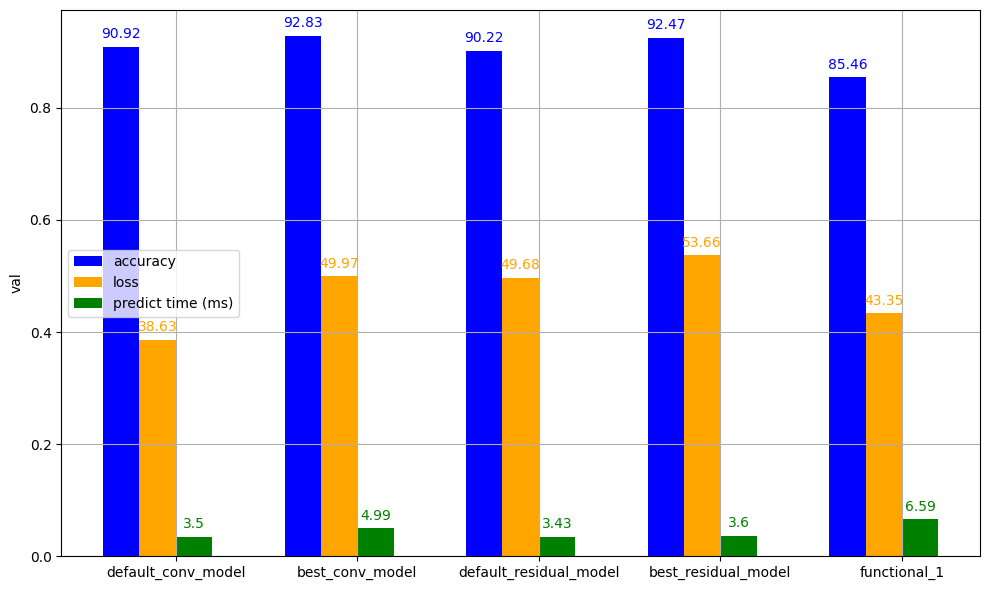

In [41]:
models = list(res_dict.keys())
accuracy = [res_dict[model]["accuracy"] for model in models]
loss = [res_dict[model]["loss"] for model in models]
predict_time = [res_dict[model]["predict_time"] for model in models]

x = range(len(models)) 
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.2  # Ширина стовпців

bar_accuracy = ax.bar([i - 1.5 * bar_width for i in x], accuracy, width=bar_width, label="accuracy", color="blue")
bar_loss = ax.bar([i - 0.5 * bar_width for i in x], loss, width=bar_width, label="loss", color="orange")
bar_predict_time = ax.bar([i + 0.5 * bar_width for i in x], predict_time, width=bar_width, label="predict time (ms)", color="green")

for color, bar in zip(["blue", "orange", "green"], [bar_accuracy, bar_loss, bar_predict_time]):
    add_bar_value(ax, bar, color)

ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylabel("val")
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

 як бачимо використання лише dense шарів є неефективним як з точки зору точності. так і з точки зору часу на передбачення.
цікавіша історія з коволюційними моделями: моделі без прокидання виявились трохи більш точними ніж residual моделі (не виключаю, що я міг просто зробити неоптимальну архітектуру). Але цікаво те, що residual моделі виявились більш швидкими в передбаченні, ніж послідовні. При чому в res моделях кількість параметрів більше ніж в звичайних. Також бачимо, що час на передбачення в res мобелях зростає з меншою залежністю від зрозстання кількості параметрів, ніж в коволюційних моделях без прокидання виходів

In [48]:
best_conv_model.layers

[<InputLayer name=input_layer, built=True>,
 <Conv2D name=conv2d, built=True>,
 <BatchNormalization name=batch_normalization, built=True>,
 <MaxPooling2D name=max_pooling2d, built=True>,
 <Conv2D name=conv2d_1, built=True>,
 <BatchNormalization name=batch_normalization_1, built=True>,
 <MaxPooling2D name=max_pooling2d_1, built=True>,
 <Flatten name=flatten, built=True>,
 <Dense name=dense, built=True>,
 <Dropout name=dropout, built=True>,
 <Dense name=dense_1, built=True>]

In [58]:
def visualize_feature_maps(model, image, max_filters_count=10):

    layer_names = [layer.name for layer in model.layers if 'conv' in layer.name and 'Conv2D' in str(layer.__class__)]
    
    # Створюємо проміжну модель. Фактично це урізана модель від input до виходів конкретного шару
    outputs = [model.get_layer(name).output for name in layer_names]
    model = Model(inputs=model.input, outputs=outputs)
    
    # так як на виході моделі коволюційний шар, ми отримаємо і його вихід - мапи ознак для поданого на предікт зображення
    feature_maps = model.predict(image)
    
    # Візуалізація активацій
    for layer_name, fmap in zip(layer_names, feature_maps):
        print(f"Шар: {layer_name} | Форма карт ознак: {fmap.shape}")
        num_filters = fmap.shape[-1]  # Кількість фільтрів
        
        # Візуалізація карт ознак для всіх фільтрів
        fig, axes = plt.subplots(1, min(num_filters, max_filters_count), figsize=(20, 5))
        fig.suptitle(f"Активації шару {layer_name}", fontsize=16)
        
        for i in range(min(num_filters, max_filters_count)):  # Показуємо максимум max_filters_count карт ознак
            ax = axes[i]
            ax.imshow(fmap[0, :, :, i], cmap='viridis')  # fmap[0] для першого зразка
            ax.axis('off')
            ax.set_title(f"Фільтр {i}")
        plt.show()


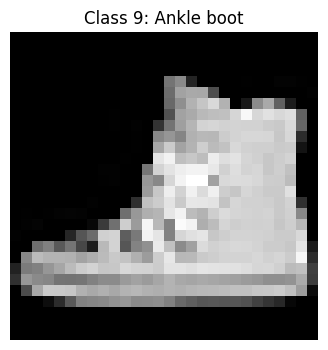


DEFAULT_CONV_MODEL:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
Шар: conv2d | Форма карт ознак: (1, 28, 28, 32)


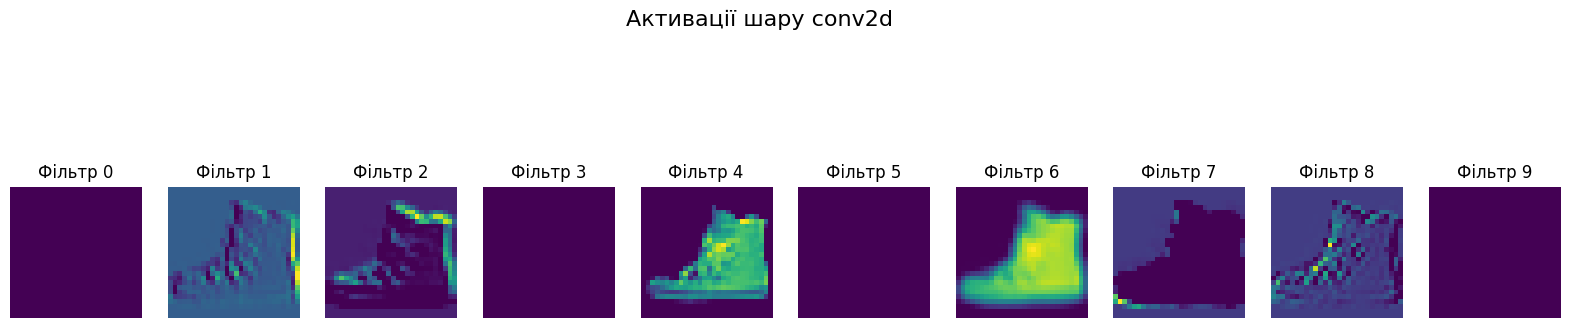

Шар: conv2d_1 | Форма карт ознак: (1, 14, 14, 64)


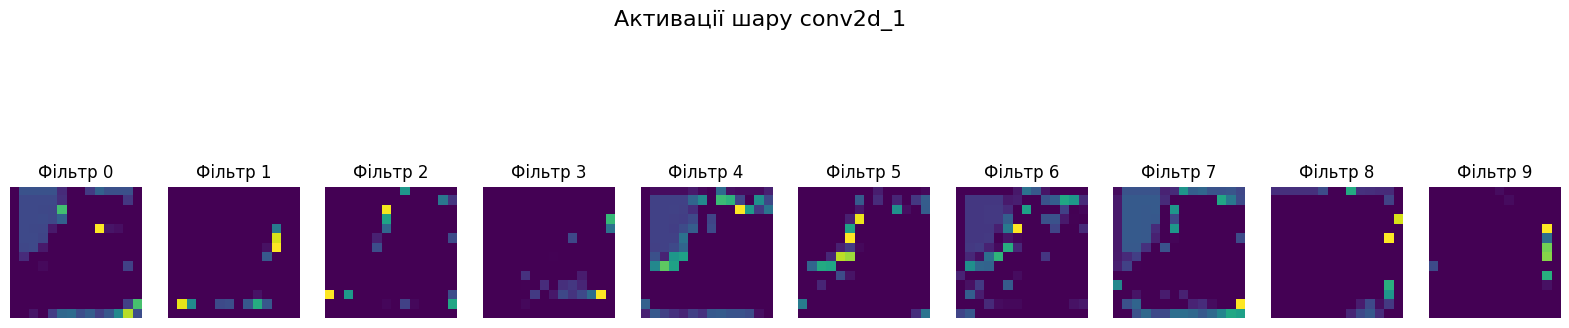


BEST_CONV_MODEL:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
Шар: conv2d | Форма карт ознак: (1, 28, 28, 64)


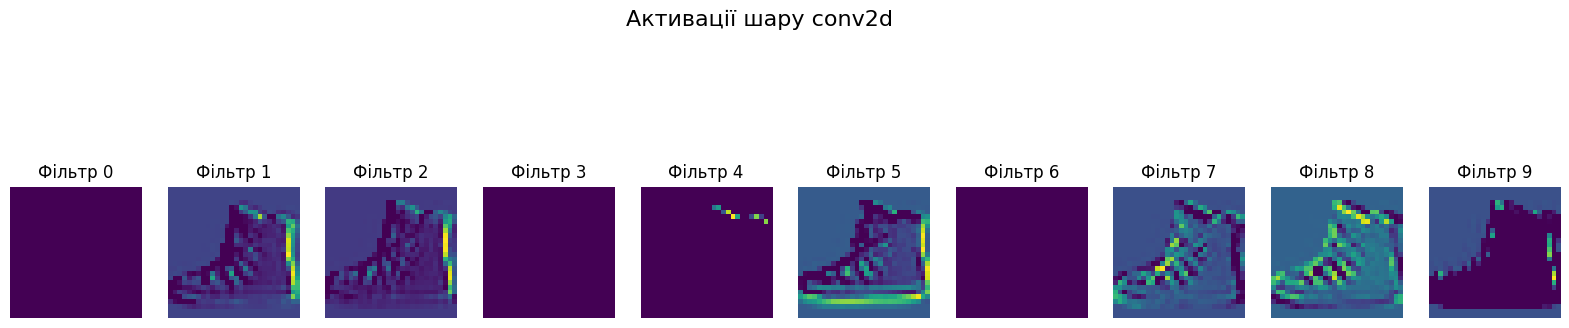

Шар: conv2d_1 | Форма карт ознак: (1, 14, 14, 192)


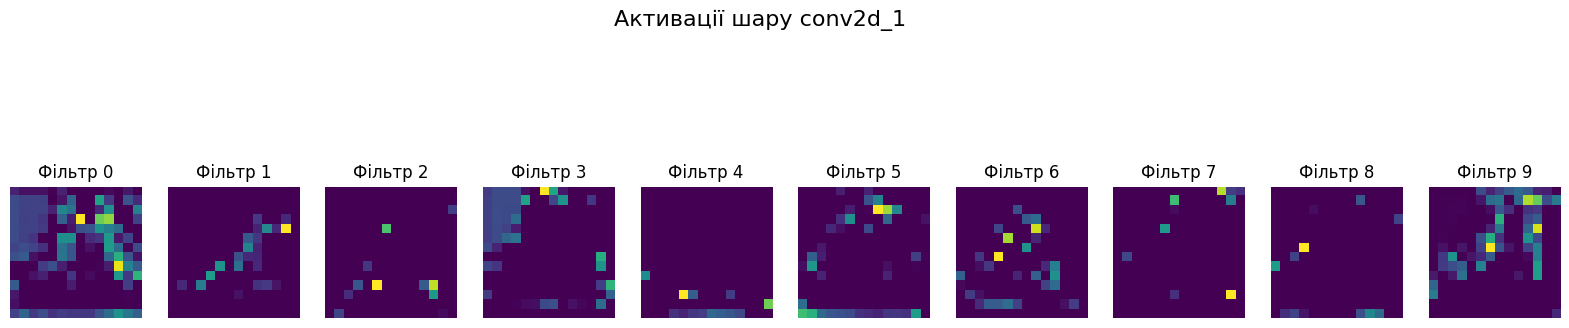


DEFAULT_RESIDUAL_MODEL:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Шар: conv2d_2 | Форма карт ознак: (1, 14, 14, 32)


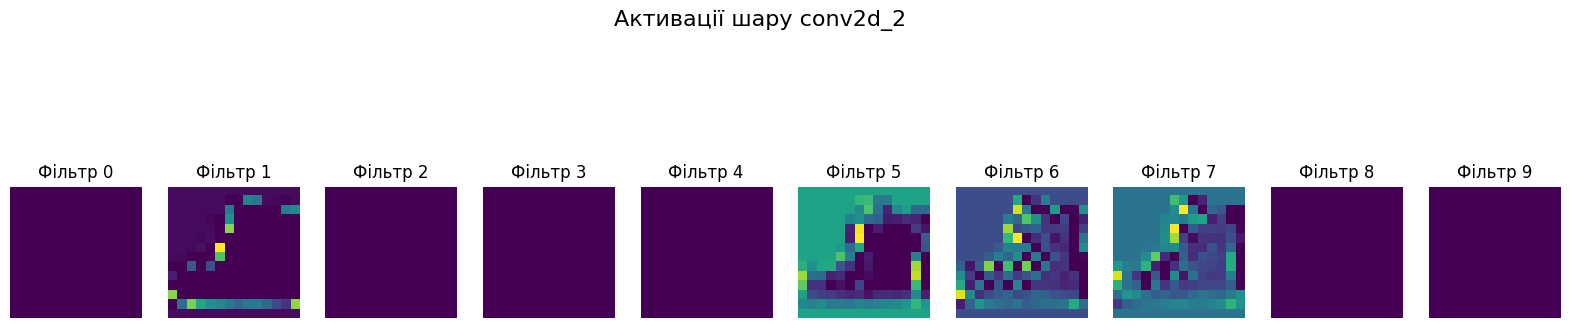

Шар: conv2d_4 | Форма карт ознак: (1, 28, 28, 32)


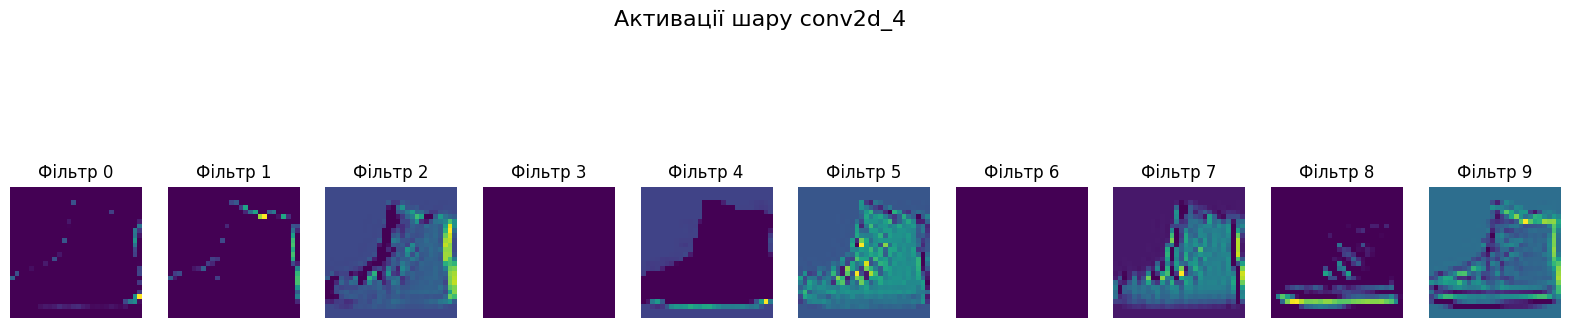

Шар: conv2d_3 | Форма карт ознак: (1, 13, 13, 64)


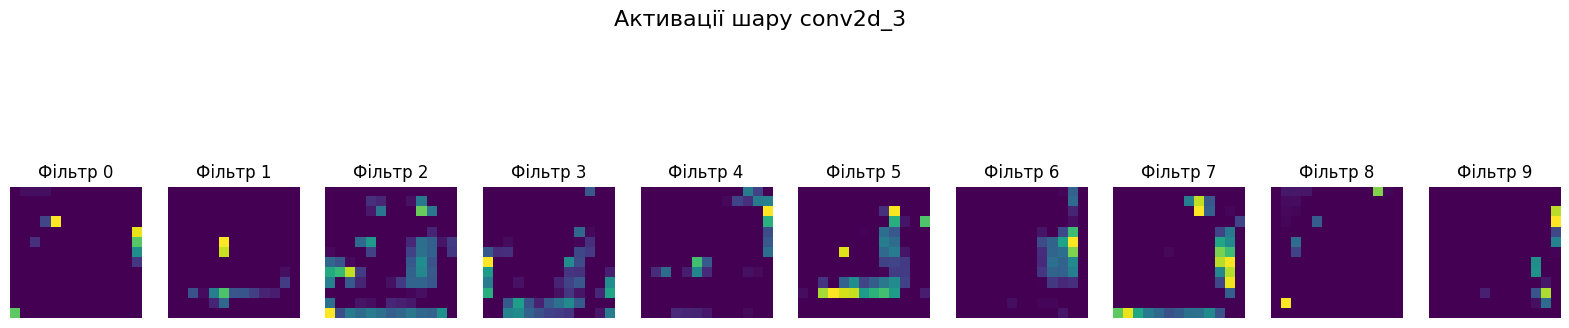

Шар: conv2d_5 | Форма карт ознак: (1, 14, 14, 64)


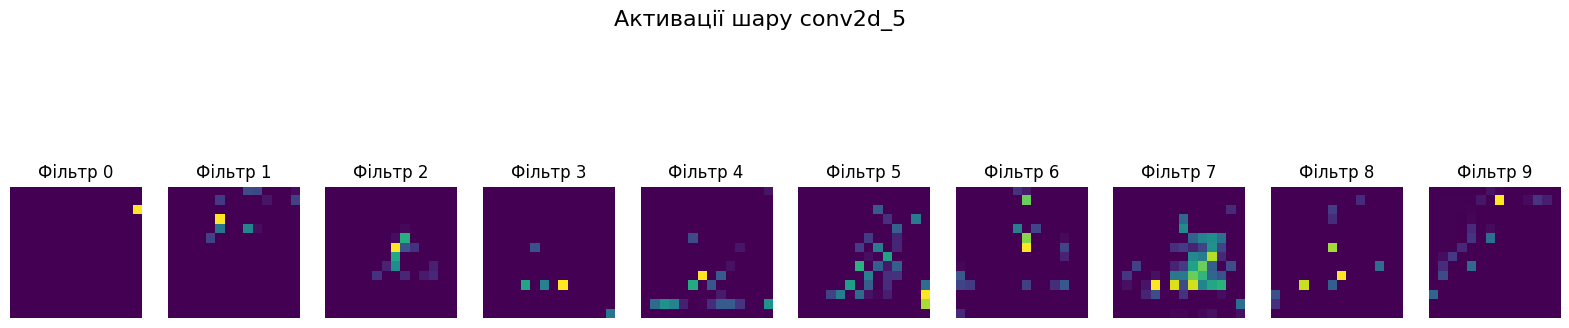


BEST_RESIDUAL_MODEL:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
Шар: conv2d | Форма карт ознак: (1, 10, 10, 64)


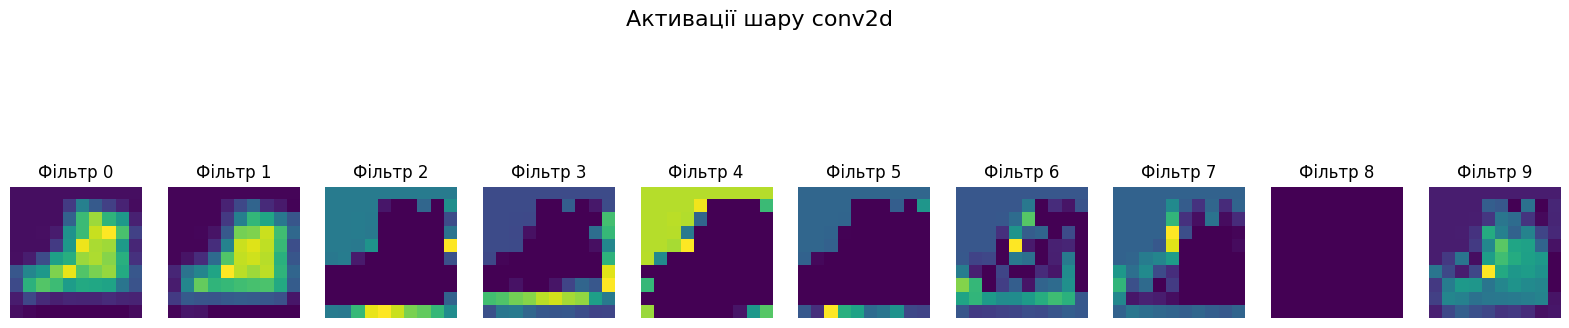

Шар: conv2d_2 | Форма карт ознак: (1, 28, 28, 64)


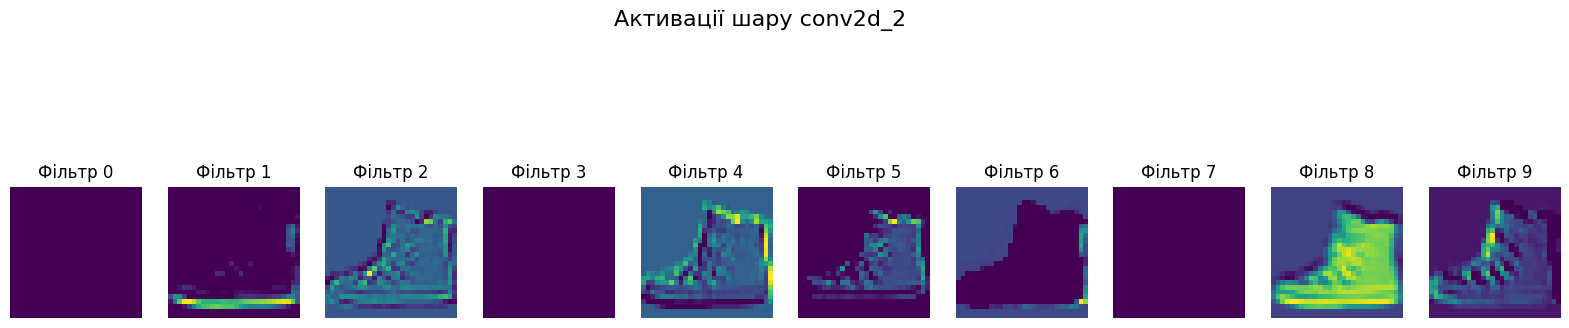

Шар: conv2d_1 | Форма карт ознак: (1, 9, 9, 128)


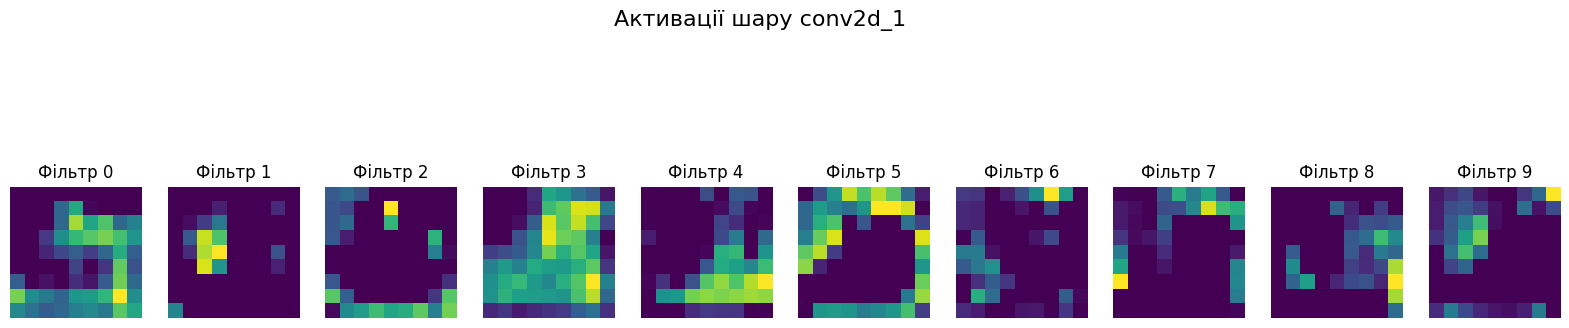

Шар: conv2d_3 | Форма карт ознак: (1, 14, 14, 128)


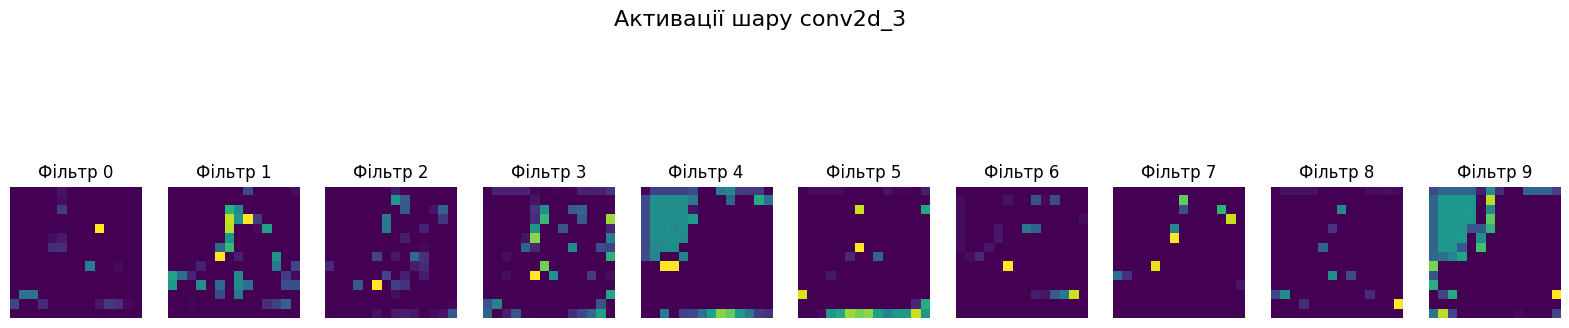

In [59]:
# Вибір випадкового зображення
random_index = np.random.randint(0, X_test.shape[0])
random_label = y_test[random_index]
sample_image = np.expand_dims(X_test[random_index], axis=0)  # Додаємо осьову для моделі

plt.figure(figsize=(4, 4))
plt.imshow(X_test[random_index].squeeze(), cmap='gray')
plt.title(f"Class {random_label}: {class_names[random_label]}")
plt.axis('off')
plt.show()

for model in [default_conv_model, best_conv_model, default_residual_model, best_residual_model]:
    print(f"\n{model.name.upper()}:")
    visualize_feature_maps(model, sample_image)


тут ми можемо добре побачити активації нейронів на конкретному зображенні. Явно стає зрозумілим, що кожний (більш глибокий) шар виділяє якісь свої більш дрібні ознаки, в той час як ближчі шари до input виділяють більш загальні та більш звичні для людини ознаки. Але використання лише таких шарів (без пулінгу чи іншого відокремлення найзначущих ознак) - потребує значно більших обчислювальних ресурсів.